# CNN single observation one-step forecast

Demo dataset and idea is from the paper CNNpred by Hoseinzade and Haratizadeh (2019)

In [1]:
import os
import random
import glob
import sys

## Building blocks

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error

# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
# to implement F1 score for validation in a batch
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1macro(y_true, y_pred):
    f_pos = f1_m(y_true, y_pred)
    # negative version of the data an dprediction
    f_neg = f1_m(1-y_true, 1-K.clip(y_pred,0,1))
    return (f_pos + f_neg)/2

def cnnpred_3d(seq_len=60, n_stocks=5, n_features=82, n_filters=(8,8,8), droprate=0.1):
    "3D-CNNpred market direction binary classification model according to the paper"
    model = Sequential([
        Input(shape=(n_stocks, seq_len, n_features)),
        Conv2D(n_filters[0], kernel_size=(1,1), activation="relu", data_format="channels_last"),
        Conv2D(n_filters[1], kernel_size=(n_stocks,3), activation="relu"),
        MaxPool2D(pool_size=(1,2)),
        Conv2D(n_filters[2], kernel_size=(1,3), activation="relu"),
        MaxPool2D(pool_size=(1,2)),
        Flatten(),
        Dropout(droprate),
        Dense(1, activation="sigmoid")
    ])
    return model

def datagen(data, seq_len, batch_size, target_index, targetcol, kind):
    "As a generator to produce samples for Keras model"
    # Learn about the data's features and time axis
    input_cols = [c for c in data.columns if c[0] != targetcol]
    tickers = sorted(set(c for _,c in input_cols))
    n_features = len(input_cols) // len(tickers)
    index = data.index[data.index < TRAIN_TEST_CUTOFF]
    split = int(len(index) * TRAIN_VALID_RATIO)
    assert split > seq_len, "Training data too small for sequence length {}".format(seq_len)
    if kind == "train":
        index = index[:split]   # range for the training set
    elif kind == 'valid':
        index = index[split:]   # range for the validation set
    else:
        raise NotImplementedError
    # Infinite loop to generate a batch
    batch = []
    while True:
        # Pick one position, then clip a sequence length
        while True:
            t = random.choice(index)
            n = (data.index == t).argmax()
            if n-seq_len+1 < 0:
                continue # this sample is not enough for one sequence length
            frame = data.iloc[n-seq_len+1:n+1][input_cols]
            # convert frame with two level of indices into 3D array
            shape = (len(tickers), len(frame), n_features)
            X = np.full(shape, np.nan)
            for i,ticker in enumerate(tickers):
                X[i] = frame.xs(ticker, axis=1, level=1).values
            batch.append([X, data[targetcol][target_index][t]])
            break
        # if we get enough for a batch, dispatch
        if len(batch) == batch_size:
            X, y = zip(*batch)
            yield np.array(X), np.array(y)
            batch = []

def testgen(data, seq_len, target_index, targetcol):
    "Return array of all test samples"
    input_cols = [c for c in data.columns if c[0] != targetcol]
    tickers = sorted(set(c for _,c in input_cols))
    n_features = len(input_cols) // len(tickers)
    t = data.index[data.index >= TRAIN_TEST_CUTOFF][0]
    n = (data.index == t).argmax()
    batch = []
    for i in range(n+1, len(data)+1):
        # Clip a window of seq_len ends at row position i-1
        frame = data.iloc[i-seq_len:i]
        target = frame[targetcol][target_index][-1]
        frame = frame[input_cols]
        # convert frame with two level of indices into 3D array
        shape = (len(tickers), len(frame), n_features)
        X = np.full(shape, np.nan)
        for i,ticker in enumerate(tickers):
            X[i] = frame.xs(ticker, axis=1, level=1).values
        batch.append([X, target])
    X, y = zip(*batch)
    return np.array(X), np.array(y)

## Model fitting

In [3]:
DATAFILES = "dataset/Processed_*.csv"
TRAIN_TEST_CUTOFF = '2016-04-21'
TRAIN_VALID_RATIO = 0.75

# Read data into pandas DataFrames
data = {} 
for filepath in glob.glob(DATAFILES):
    X = pd.read_csv(filepath, index_col="Date", parse_dates=True)
    # basic preprocessing: get the name, produce the classification target
    # Save the target variable as a column in dataframe for easier dropna()
    name = X["Name"][0]
    del X["Name"]
    cols = X.columns
    X["Target"] = (X["Close"].pct_change().shift(-1) > 0).astype(int)
    X.dropna(inplace=True)
    # Fit the standard scaler using the training dataset
    index = X.index[X.index < TRAIN_TEST_CUTOFF]
    index = index[:int(len(index) * TRAIN_VALID_RATIO)]
    scaler = StandardScaler().fit(X.loc[index, cols])
    # Save scale transformed dataframe
    X[cols] = scaler.transform(X[cols])
    data[name] = X

# Transform data into 3D dataframe (multilevel columns)
for key, df in data.items():
    df.columns = pd.MultiIndex.from_product([df.columns, [key]])
data = pd.concat(data.values(), axis=1)

# Input data sample: 60-day x 5 stocks x 82 features
# Training in SGD with batch size 128 and 50 epochs
seq_len    = 60
n_features = 82
n_stocks   = 5
batch_size = 128
n_epochs   = 50

# Construct CNNpred as a binary classification problem
model = cnnpred_3d(seq_len, n_stocks, n_features)
model.compile(optimizer="adam", loss="mae", metrics=["acc", f1macro])
model.summary(line_length=100) # print model structure to console

Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d (Conv2D)                             (None, 5, 60, 8)                        664            
                                                                                                    
 conv2d_1 (Conv2D)                           (None, 1, 58, 8)                        968            
                                                                                                    
 max_pooling2d (MaxPooling2D)                (None, 1, 29, 8)                        0              
                                                                                                    
 conv2d_2 (Conv2D)                           (None, 1, 27, 8)                        200            
                                                                       

2021-12-13 23:10:29.955352: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2021-12-13 23:10:29.955374: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: acer
2021-12-13 23:10:29.955379: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: acer
2021-12-13 23:10:29.955437: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2021-12-13 23:10:29.955453: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2021-12-13 23:10:29.955457: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5
2021-12-13 23:10:29.955597: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations

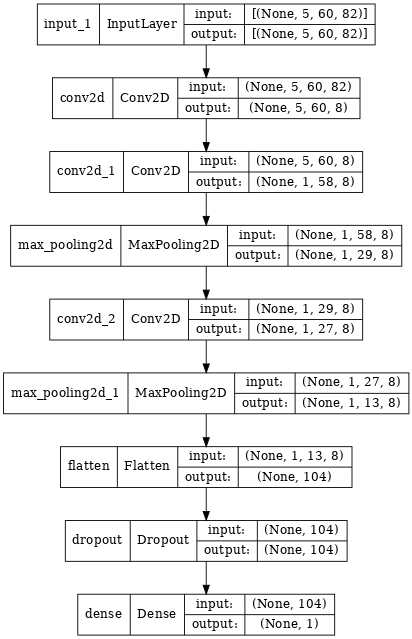

In [4]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, dpi=64)

In [5]:
# Set up callbacks and fit the model with target on DJI
# We use custom validation score f1macro() and hence monitor for "val_f1macro"
checkpoint_path = "cnn3d-{epoch}-{val_f1macro:.2f}.h5"
callbacks = [
    ModelCheckpoint(checkpoint_path,
                    monitor='val_f1macro', mode="max",
                    verbose=0, save_best_only=True, save_weights_only=False, save_freq="epoch"),
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
]
model.fit(datagen(data, seq_len, batch_size, "DJI", "Target", "train"),
          validation_data=datagen(data, seq_len, batch_size, "DJI", "Target", "valid"),
          epochs=n_epochs, steps_per_epoch=400, validation_steps=10, verbose=1, callbacks=callbacks)

Epoch 1/50
400/400 [==============================] - 225s 562ms/step - loss: 0.3387 - acc: 0.6889 - f1macro: 0.6279 - val_loss: 0.4510 - val_acc: 0.5609 - val_f1macro: 0.5328
Epoch 2/50
400/400 [==============================] - 229s 573ms/step - loss: 0.1655 - acc: 0.8608 - f1macro: 0.8563 - val_loss: 0.4694 - val_acc: 0.5094 - val_f1macro: 0.4793
Epoch 3/50
400/400 [==============================] - 227s 570ms/step - loss: 0.1213 - acc: 0.8943 - f1macro: 0.8910 - val_loss: 0.4800 - val_acc: 0.5156 - val_f1macro: 0.4793
Epoch 4/50
400/400 [==============================] - 219s 550ms/step - loss: 0.0982 - acc: 0.9127 - f1macro: 0.9100 - val_loss: 0.4580 - val_acc: 0.5297 - val_f1macro: 0.5004


In [6]:
# Prepare test data
test_data, test_target = testgen(data, seq_len, "DJI", "Target")

# Test the model
test_out = model.predict(test_data)
test_pred = (test_out > 0.5).astype(int)
print("accuracy:", accuracy_score(test_pred, test_target))
print("MAE:", mean_absolute_error(test_pred, test_target))
print("F1:", f1_score(test_pred, test_target))

accuracy: 0.5170731707317073
MAE: 0.48292682926829267
F1: 0.668896321070234
